In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#The following allow direct FEniCS code into python scripts.

def ln(input):
    return np.log(input)

def Constant(constant):
    return constant

In [4]:
epsmet = 0

def Dubinin_Astakhov(p,t): #[kg/m3] Equilibrium Density of Adsorbed Gas
    return rhoads_T(t)*Ws(epsmet)*exp(-pow((Rg * t * ln(Psat_YAWS_1999(t)/(p))/(E0_beta)),ads_ns))

def Ws(epsmet):
    return (1-epsTotal(epsmet))*ads_rho_bulk*ads_ws 

def rhoads_T(t): #Ps [mmHg] using the conversion 1 mmHg = 133.322Pa, 
    Psat_D = Constant(29.8605)
    Psat_E = Constant(-3152.2)
    Psat_F = Constant(-7.3037)
    Psat_G = Constant(2.4247e-9)
    Psat_H = Constant(1.8090e-6)
    return 133.322*pow(10,(Psat_D + Psat_E / t + Psat_F*ln(t)/ln(10) + t*Psat_G + Psat_H*pow(t,2) ))  #133.332 Pa to 1 mmHg

In [5]:
def Ambrozek(temp):
    return .01 

def Knudsen(t): #Also referred to as intercrystalline Diffusivity
    eps = epsTotal(epsmet)    
    dp = Constant(5.7e-7)  ##Characteristic void size, Mean pore diameter, [m],
    Rw = 461.52 
    return (dp/3)*pow(8*Rg*t/(3.14*vap_mg),1/2)

def Narayanan(t): # Effective Vapor Intercrystalline Diffusivity (2014)
    return  Constant(15)*Dc/pow(ads_rps,2)* exp(-Ea/(Rg*T0)*(1-t/T0))     

def Vasiliev(t): #Vasiliev
    return Constant(15) * Dc / pow(ads_rps,2) *exp(-Ea/(Rw*t)) 

def Mette(t,temp0,p,p0): #Mette 
    #Sp = 6/ads_dps
    Qeq = Dubinin_Astakhov(p,t)
    Qeq0 = Dubinin_Astakhov(p0,t0) 
    Pw0 = Rg*vap_mg*Qeq0*t #mbar
    Pw = Rg*vap_mg*Qeq*t #mbar
    Qeq = Dubinin_Astakhov(p,t)
    Qeq0 = Dubinin_Astakhov(p0,t0) 
    dQeq = (Qeq - Qeq0)/ads_rho_bulk*1000 
    dPw = (Pw - Pw0)
    ads_dps = Constant(1e-6)
    ads_tort = Constant(4)
    mu = 4 #Tortuosity
    eps = epsTotal(epsmet) # 
    Rw = 461.52 #[J/kg K]
    Dm =  Constant(5e-15) #Macro Pore Diffusion Resistance, Superposition of molecular diffusion and gas diffusion
    return 15/pow(ads_dps,2) *Dm  / ads_tort * eps/(ads_rho_crystal*Rw*t) * (1/(dQeq/dPw)) #


In [6]:
patm = 101325 # Pa
t = 298.15 # K
p = Psat_YAWS_1999(t)

# r = [kg adsorbate / adsorbant m3] 
relativePressure_list = np.linspace(.01,.5,100)
#Relative Pressure = Partial Pressure H2O aka Vapor Pressure / Pressure Water Saturation

#Po_list = [3.5,15,44,1830]

temp_list = np.linspace(273.15, 373.15, 100)
temp0_list = np.append([273.15],temp_list[:-1])

G_Narayanan_list = []
G_Mette_list = []
G_Vasiliev_list = []
G_Ambrozek_list = []
G_Knudsen_list = []

for i in range(0,len(temp_list)):
    temp = temp_list[i]
    temp0 = temp0_list[i]
    G_Narayanan_list.append(Narayanan(temp))
    G_Vasiliev_list.append(Vasiliev(temp))
    G_Ambrozek_list.append(Ambrozek(temp))
    #G_Mette_list.append(Mette(t,temp0,p))
    G_Knudsen_list.append(Knudsen(temp))
    

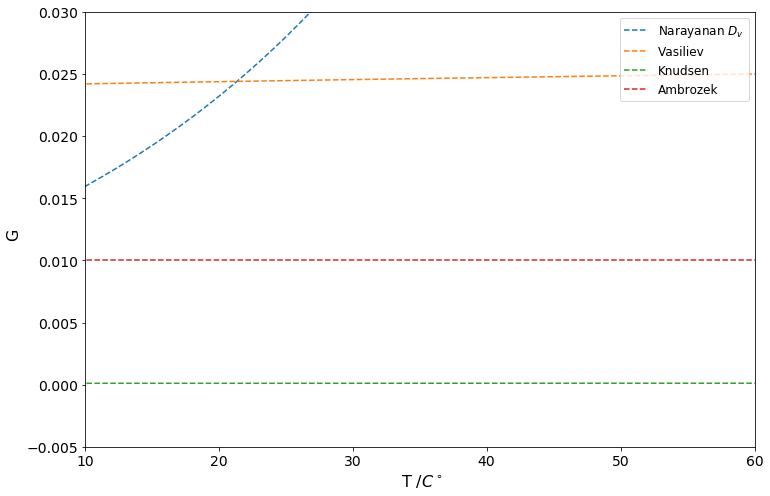

In [12]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('')

ax.plot(temp_list-273.15,G_Narayanan_list, label=r"Narayanan $D_v$", linestyle='dashed')
ax.plot(temp_list-273.15,G_Vasiliev_list, label="Vasiliev", linestyle='dashed')
#ax.plot(temp_list-273.15,G_Mette_list, label="Mette", linestyle='dashed')
ax.plot(temp_list-273.15,G_Knudsen_list, label="Knudsen", linestyle='dashed')
ax.plot(temp_list-273.15,G_Ambrozek_list, label="Ambrozek", linestyle='dashed')

plt.xticks(fontsize=14 )
plt.yticks(fontsize=14 )
ax.set_xlabel(r' T /$C^\circ$',fontsize=16)
ax.set_ylabel(r'G  ',fontsize=16)
ax.set_xlim(10,60) #return to zero after chain 50 computed.
ax.set_ylim(-.0050,0.03)
ax.plot()
ax.legend(fontsize=12)  
fig.savefig('De.png')
plt.show()



In [8]:
#Unused
def Kim(t): # Effective Vapor Intercrystalline Diffusivity ()
    Eu = Constant(2.8035e4) #Activation Energy for surface diffusion [J/mol]
    Du0 = Constant(5.0e-16) #Intracrystalline Gas Diffusivity at T0 [m2/s]    
    T0 = 300
    D_vap = 0#Vapour molecular diffusivity in air
    D_k_vap = (dp/3)*pow(8*Rg*t/(3.14*vap_mg),1/2) #Knudsen Diffusivity of vapor 
    return pow(eps,3/2)*pow(1/D_vap + 1/D_k_vap ,-1)

def DAB(t):
    sigma_a =1
    sigma_b =1
    sigma_ab = .5*(sigma_a*sigma_b)
    omega_d = 1
    M_a = 1
    M_b = 1
    return 0.001858*pow(t,3/2)/(patm*pow(sigma_ab,2)*omega_d )*pow((1/M_a+1/M_b),1/2) #[cm2/s]
def Chan(t):
    Du0 = Constant(3.92e-6) # [m2/s] Chan (2012)
    #Du0 = Constant(5.0e-16)
    Ea = Constant(2.8035e4) # Activation Energy for surface diffusion [J/mol]
    ads_rps = Constant(2e-6)/2
    Ks0 = 15* Du0 / pow(ads_rps,2) 
    return Ks0 * exp(-Ea/(Rg*t))

def Narayanan2(t): #Effective Vapor Intercrystalline Diffusivity (2017)
    return 15*Dc/pow(ads_rps,2)
